In [ ]:
import sisl
import numpy as np
from hubbard import HubbardHamiltonian, sp2, density, NEGF, plot
import matplotlib.pyplot as plt
%matplotlib inline

# Open quantum systems (Green’s functions)

In this example we will study the effect of on-site Coulomb repulsion interactions in an open-quantum system, and find the self-consistent solution to the mean-field Hubbard Hamiltonian using the non-equilibrium Green's function (NEGF) formalism within the `hubbard` package.

Here we will reproduce the results presented in [Phys. Rev. B 81, 245402 (2010)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.245402) for the system shown in Fig. 3:
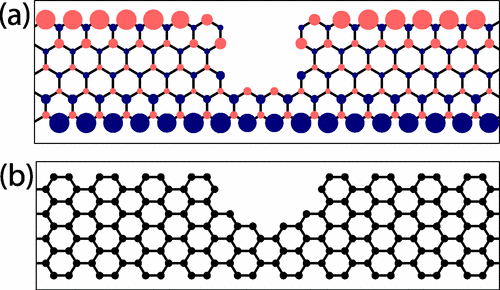

This is, a zigzag graphene nanoribbon with a defect created by removing certain atoms in the central region. On panel (a) of the figure above we see the spin polarization, which we will reproduce here.
This open-quantum system is composed by a central region that contains the defect coupled to two semi-infinite leads or electrodes (left and right).

The transmission probabilities should look something like Fig. 4 shown in [Phys. Rev. B 81, 245402 (2010)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.245402):
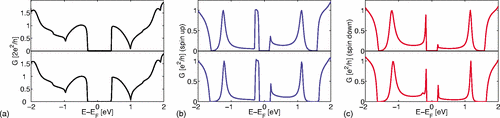

We will focus on the equilibrium situation, therefore the temperature and chemical potentials of the electrodes *must coincide*. The complex contour that we use to integrate the density matrix in the `hubbard.NEGF` class is extracted from a [TranSiesta](https://gitlab.com/siesta-project/siesta) calculation performed for a temperature of `kT=0.025` eV, which we will set as common for all the composing element calculations.


In [ ]:
# Set U and kT for the whole calculation (use these values when needed)
U = 2.0
kT = 0.025

#### 1) Compute the electrodes 
We will start by building the tight-binding (TB) Hamiltonian for the graphene nanoribbons, which compose the electrodes (periodic boundary conditions). Then we will find their self-consistent solution by using the `hubbard` package. Look into excercise [MFH 2](../MFH_2/run.ipynb) for more information

In [ ]:
# Build sisl.Geometry object of a ZGNR of width W=5 C-atoms across,
# e.g., by using the function sisl.geom.zgnr.
# This function returns the unit-cell of a periodic ZGNR along the x-axis.
ZGNR = sisl.geom.zgnr(5)

# Build tight-binding Hamiltonian using sp2 function
H_elec = sp2(ZGNR, t1=2.7, t2=0.2, t3=0.18, s1=0, s2=0, s3=0)

# Build the HubbardHamiltonian object for the periodic system:
MFH_elec = HubbardHamiltonian(H_elec, nkpt=[100, 1, 1], U=U, kT=kT)

# Initialize electrodes spin density
MFH_elec.set_polarization([0], dn=[9])

# Converge Electrode Hamiltonians
dn = MFH_elec.converge(density.calc_n, tol=1e-5, print_info=True)

Plot the spin polarization of the unit cell to check out the self-consistent solution

In [ ]:
p = plot.SpinPolarization(MFH_elec, colorbar=True, vmax=0.4, vmin=-0.4)

#### 2) Build the device (scattering region)
The next step is to build the geometry of the device. The system is composed by a series of repetitions of the electrode and a defect in the center (scattering region). We also have to make sure that the device is not periodic along the transport direction.

In [ ]:
# Build central region TB Hamiltonian
HC = H_elec.tile(16, axis=0)

# Remove atoms in the central area to recreate the system of Fig. 3 (a) of the reference paper.
HC = HC.remove([67, 68, 69, 72, 73, 74, 77, 78, 79, 82, 83, 84, 87, 88, 89])

# Cut periodicity along the transport direction (first axis)
HC.set_nsc([1, 1, 1])

# Plot geometry
p = plot.GeometryPlot(HC.geometry)

#### 3) Obtain the spin-density for the open-quantum system

- Create the `HubbardHamiltonian` object for the device system

The `NEGF` is a class of the `hubbard` package, therefore the first step is to create the `NEGF` object for the device and electrodes. To build this object one has to pass the following arguments:

- the non-converged `HubbardHamiltonian` object of the device
- a list that contains all the electrodes in the device with its semi-infinite direction, e.g. `[(ElecA, DirA), (ElecB, DirB), ...]`. Where `ElecA`, `ElecB` stand for the names of the variables of the `HubbardHamiltonian` of the *converged* electrodes' Hamiltonians, while `DirA`, `DirB` stand for the semi-infinite direction of each electrode. Following `sisl` notation these directions can be: `-A,+A,-B,+B,-C,+C` for semi-infinite direction along the first, second or third axes (`A,B,C`), respectively. The sign indicates the sense towards the semi-infinite lead grows.
- the atomic positions of where the electrodes are mapped in the device.

Then you can converge the Hamiltonian of this open quantum system by using the methods of the `NEGF` class.

In [ ]:
# Create the HubbardHamiltonian for the device
MFH_HC = HubbardHamiltonian(HC, U=U, kT=kT)

# Initialize spin densities!
# We will start with polarization on the lower and upper edges of the zigzag nanorribon:
lower = np.where(MFH_HC.geometry.xyz[:,1] == np.amin(MFH_HC.geometry.xyz[:,1]))[0]
upper = np.where(MFH_HC.geometry.xyz[:,1] == np.amax(MFH_HC.geometry.xyz[:,1]))[0]
MFH_HC.set_polarization(lower, dn=upper)

# Define the electrode atomic positions inside the device (in this case, the first and last blocks):
elec_indx = [range(len(H_elec)), range(-len(H_elec), 0)]

# Create the NEGF object for the device and electrodes. This class will allow you to use the methods
# to solve open-quantum systems with the Green's function formalism
negf = NEGF(MFH_HC, [(MFH_elec, '-A'), (MFH_elec, '+A')], elec_indx)

# Use the method negf.calc_n_open to converge the device Hamiltonian:
dn = MFH_HC.converge(negf.calc_n_open, steps=1, tol=1e-5, func_args={'qtol': 1e-4}, print_info=True)

In [ ]:
# Now we have the converged device Hamiltonian, let's plot the spin polarization
p = plot.SpinPolarization(MFH_HC, colorbar=True, vmax=0.4, vmin=-0.4)

## Try it yourself

Having solved the mean-field Hubbard Hamiltonian with the NEGF formalism allows us to perform other interesting calculations such as transport simulations for this open quantum system. For instance, one can obtain the transmission probabilities per spin channel. 
Look into example [TB_04](https://github.com/zerothi/ts-tbt-sisl-tutorial/blob/main/TB_04/run.ipynb) for more information about how [TBtrans](https://gitlab.com/siesta-project/siesta) and [sisl](https://zerothi.github.io/sisl) can be combined. You should:

1. Align both electrodes and device Hamiltonians with their "Fermi levels"
```python
MFH_elec.shift(-MFH_elec.fermi_level())
MFH_HC.shift(-negf.Ef)
```
Note that this is an *in-place operation*.

2. Write each Hamiltonian in `netCDF4` format (suitable for a `TBtrans` calculation):

```python
MFH_elec.H.write('MFH_elec.nc')
MFH_HC.H.write('MFH_HC.nc')
```

3. There is an input file (`RUN.fdf`) for `TBtrans` in this directory, you may want to use it to run `TBtrans` to obtain the transmission probabilities per spin channel, which you can extract with `sisl` to plot them.
In this calculation you will find two different `TBtrans` output files, one for each spin index with the following suffixes `*.TBT_UP.nc` and `*.TBT_DN.nc`. So you can extract the transmission stored in each of them and plot them both on the same figure:

```python
# Extract output from TBtrans
tbt_up = sisl.get_sile('<file name>.TBT_UP.nc')
tbt_dn = sisl.get_sile('<file name>.TBT_DN.nc')

# Plot transmissions
plt.plot(tbt_up.E, tbt_up.transmission(0, 1), label='spin up')
plt.plot(tbt_dn.E, tbt_dn.transmission(0, 1), label='spin dn')
plt.legend()
plt.xlim(-2, 2)
plt.xlabel('Energy [eV]')
plt.ylabel('Transmission')
```